# QRT ENS Data Challenge 2023 - Benchmark (english)

This notebook details the benchmark construction for the challenge - it may also help participants to start the competition.

## Libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## Loading data

- `X_train` and `X_test` both have $35$ columns that represent the same explanatory variables but over different time periods. 

- `X_train` and `Y_train` share the same column `ID` - each row corresponds to a unique ID associated wwith a day and a country. 

- The target of this challenge `TARGET` in `Y_train` corresponds to the price change for daily futures contracts of 24H electricity baseload. 

- **You will notice some columns have missing values**.


In [2]:
# After downloading the X_train/X_test/Y_train .csv files in your working directory:

X_train = pd.read_csv('../X_train_NHkHMNU.csv')
Y_train = pd.read_csv('../y_train_ZAN5mwg.csv')
X_test = pd.read_csv('../X_test_final.csv')
X_test.shape

(654, 35)

In [3]:
X_train.shape, Y_train.shape

((1494, 35), (1494, 2))

## Model and train score

The benchark for this challenge consists in a simple linear regression, after a light cleaning of the data: The missing (NaN) values are simply filled with 0's and the `COUNTRY` column is dropped - namely we used the same model for France and Germany. 

In [4]:
lr = LinearRegression()

X_train_clean = X_train.drop(['COUNTRY'], axis=1).fillna(0)
Y_train_clean = Y_train['TARGET']

X_train_clean, X_val, y_train, y_val = train_test_split(X_train_clean, Y_train_clean, test_size=0.1, random_state=0)

lr.fit(X_train_clean, y_train)

output_train    = lr.predict(X_train_clean)
output_val      = lr.predict(X_val)
output_val_df   = pd.DataFrame(lr.predict(X_val), index=X_val.index, columns=["prediction"])

def metric_train(output, y):

    return  spearmanr(output, y).correlation

print('Spearman correlation for the train set: {:.1f}%'.format(100 * metric_train(output_train, y_train) ))
print('Spearman correlation for the val   set: {:.1f}%'.format(100 * metric_train(output_val, y_val) ))
print(X_train_clean.shape)

Spearman correlation for the train set: 28.2%
Spearman correlation for the val   set: 20.3%
(1344, 34)


In [5]:
output_val_df.head()

,prediction
799,0.005157
1047,0.317522
1436,-0.567432
54,0.241009
793,0.319273


The Spearman correlation obtained with our model on the train data set is about 27.9%.

NB: Electricity price variations can be quite volatile and this is why we have chosen the Spearman rank correlation as a robust metric for the challenge, instead of the more standard Pearson correlation.

## Generate the benchmark output

Next, we process the test set the same way as we did on the train set and predict using our linear model, while saving the predictions to a csv file satisfying the challenge output contraints.


In [6]:
X_test_clean = X_test.drop(['COUNTRY'], axis=1).fillna(0)

Y_test_submission = X_test[['ID']].copy()
Y_test_submission['TARGET'] = lr.predict(X_test_clean)
Y_test_submission_origi = Y_test_submission.copy()

Y_test_submission.to_csv('benchmark_qrt.csv', index=False)

Y_test_submission.head()

,ID,TARGET
0,1115,-0.077957
1,1202,0.094718
2,1194,-0.280132
3,1084,-0.068293
4,1135,-0.005410


After submitting this benchmark_qrt.csv file at https://challengedata.ens.fr, we obtain a public score of around 15.9 % - this is the score to beat!


## Tips and ideas for improvements 

- Thinking about the fundamental price drivers of electricity in each country may be useful. 

- The dataset is small, so you will need to be careful not to overfit your models. It will be useful to use good crossvalidation practices. 


In [21]:
remove_collinearities = True
mutual_info_corr = False
Number_feature = {}
Number_feature["FR"] = 8
Number_feature["DE"] = 2
Number_feature["tot"] = 1

combine_features = True

VAL_FRACTION = 0.2

In [22]:

def combine_feature_func(df):
    # --- 1. Rapporti e quote energetiche statiche ---
    df["DE_LOAD_RATIO"] = df["DE_RESIDUAL_LOAD"] / (df["DE_CONSUMPTION"] + 1e-6)
    df["FR_LOAD_RATIO"] = df["FR_RESIDUAL_LOAD"] / (df["FR_CONSUMPTION"] + 1e-6)
    df["DE_RENEW_SHARE"] = (df["DE_WINDPOW"] + df["DE_SOLAR"]) / (df["DE_CONSUMPTION"] + 1e-6)
    # df["DE_RENEW_TOT"] = df["DE_WINDPOW"] + df["DE_SOLAR"] + df["DE_HYDRO"]
    df["DE_RENEW_WO_HYDRO"] = df["DE_WINDPOW"] + df["DE_SOLAR"] 
    df["FR_RENEW_WO_HYDRO"] = df["FR_WINDPOW"] + df["FR_SOLAR"]
    df["FR_RENEW_TOT"] = df["FR_WINDPOW"] + df["FR_SOLAR"] + df["FR_HYDRO"] 

    df["DE_CONSUMPTION_RATIO"] = df["DE_CONSUMPTION"] / df["DE_RENEW_WO_HYDRO"]

    df["FR_RENEW_SHARE"] = (df["FR_WINDPOW"] + df["FR_SOLAR"]) / (df["FR_CONSUMPTION"] + 1e-6)
    df["FR_NUC_SHARE"] = df["FR_NUCLEAR"] / (df["FR_CONSUMPTION"] + 1e-6)
    df["FR_NUC_AA"] = df["FR_NUCLEAR"] * (df["FR_CONSUMPTION"] + 1e-6)
    df["EXCHANGE_BALANCE"] = df["DE_FR_EXCHANGE"] - df["FR_DE_EXCHANGE"]

    # --- 2. Differenze giornaliere (dinamiche temporali) ---
    diff_cols = ["DE_CONSUMPTION", "FR_CONSUMPTION", 
        "DE_RESIDUAL_LOAD", "FR_RESIDUAL_LOAD", 
        "DE_WINDPOW", "FR_WINDPOW", "DE_SOLAR", "FR_SOLAR",  
        "DE_NUCLEAR", "FR_NUCLEAR", 
        "DE_COAL", "FR_COAL", "DE_GAS", "FR_GAS", 
        "GAS_RET", "COAL_RET", "CARBON_RET", 
        "DE_FR_EXCHANGE", "FR_DE_EXCHANGE" ]

    for c in diff_cols:
        df[f"{c}_DIFF"] = df.groupby("COUNTRY")[c].diff() #* df[c]
        # df[f"{c}_DIFF_FR"] = df.groupby("COUNTRY")[c].diff() * df.groupby("COUNTRY")["DE_CONSUMPTION"]

    df["AA"] = df["CARBON_RET"] * df["FR_COAL"]**2
    df["BB"] = df["GAS_RET"] * df["FR_GAS"]**2

    # --- 3. Differenze relative (variazione percentuale) ---
    for c in diff_cols:
        df[f"{c}_RELDIFF"] = df[f"{c}_DIFF"] / (df[c].shift(1) + 1e-6)

    # --- 4. Spread e variazioni bilaterali ---
    df["TEMP_SPREAD"]        = df["DE_TEMP"]        - df["FR_TEMP"]
    df["LOAD_SPREAD"]        = df["DE_LOAD_RATIO"]  - df["FR_LOAD_RATIO"]
    df["RENEW_SPREAD"]       = df["DE_RENEW_SHARE"] - df["FR_RENEW_SHARE"]
    df["CONSUMPTION_SPREAD"] = df["DE_CONSUMPTION"] - df["FR_CONSUMPTION"]

    # --- 5. Costi marginali e variazioni nei costi ---
    df["DE_COST_GAS"]  = df["DE_GAS"]  * df["GAS_RET"]
    df["DE_COST_COAL"] = df["DE_COAL"] * df["COAL_RET"]
    df["FR_COST_GAS"]  = df["FR_GAS"]  * df["GAS_RET"]
    df["FR_COST_COAL"] = df["FR_COAL"] * df["COAL_RET"]
    df["DE_COST_LIGNITE"] = df["DE_LIGNITE"] * df["CARBON_RET"]
    for c in ["DE_COST_GAS", "DE_COST_COAL", "FR_COST_GAS", "FR_COST_COAL"]:
        df[f"{c}_DIFF"] = df.groupby("COUNTRY")[c].diff()

    # --- 6. Termini quadratici (non linearità dolci) ---
    df["CARBON_RET_SQ"] = df["CARBON_RET"]**2
    df["GAS_RET_SQ"]    = df["GAS_RET"]**2
    df["COAL_RET_SQ"]   = df["COAL_RET"] ** 2

    # --- 7. Interazioni di flusso e produzione ---
    df["FR_EXPORT_IMPACT"] = df["FR_NET_EXPORT"] * df["FR_NUCLEAR"]
    df["DE_EXPORT_IMPACT"] = df["DE_NET_EXPORT"] * df["DE_WINDPOW"]

    return df

In [23]:
from sklearn.feature_selection import mutual_info_regression

X_train = pd.read_csv('../X_train_NHkHMNU.csv')
X_test  = pd.read_csv('../X_test_final.csv')
Y_train = pd.read_csv('../y_train_ZAN5mwg.csv')

X_tot  = X_train.copy().fillna(0)

f_tot = X_tot.merge(Y_train,on=['ID'],how="left").fillna(0)

f_tot["benchmark"] = np.nan
f_tot.loc[output_val_df.index,"benchmark"] = output_val_df["prediction"]

if combine_features:
    f_tot = combine_feature_func(f_tot)
    X_test = combine_feature_func(X_test)

feat = {}
corr_df_tot = []
for country in ["DE","FR", "tot"]:
    mask = (f_tot["COUNTRY"] == country)
    if country == "tot":
        mask = ~mask

    corr_matrix = f_tot[mask].drop(columns=["COUNTRY","TARGET","benchmark"]).corr(method="spearman")
    # --- mutual information al posto di spearman ---
    if mutual_info_corr:
        X = f_tot[mask].drop(columns=["COUNTRY","TARGET","benchmark"]).fillna(0)
        y = f_tot[mask]["TARGET"]
        mi   = mutual_info_regression(X, y, random_state=0)
        corr = pd.Series(mi, index=X.columns)
    else:
        corr = f_tot[mask].drop(columns=["COUNTRY","TARGET","benchmark"]).corrwith(f_tot[mask]["TARGET"],method="spearman")


    corr_df = corr.to_frame(name="correlation").reset_index()
    corr_df["abs corr"] = np.abs(corr_df["correlation"])
    corr_df_tot.append(corr_df.sort_values(by="abs corr",ascending=False))

    if Number_feature[country]<corr_df_tot[-1].iloc[:].shape[0]:
        feat[country] = list(corr_df_tot[-1].iloc[0:Number_feature[country]]["index"])
    else:
        mask = (corr_df_tot[-1]["abs corr"] >= 0.02)
        feat[country] = list(corr_df_tot[-1][mask]["index"])
    print("____________________________")
    print(country)
    print(corr_df_tot[-1].iloc[0:10])
    print("____________________________")
    

Y_test_submission    = X_test[['ID']].copy();


____________________________
DE
                    index  correlation  abs corr
23       DE_RESIDUAL_LOAD     0.324335  0.324335
8           DE_NET_IMPORT     0.306204  0.306204
6           DE_NET_EXPORT    -0.306204  0.306204
20             DE_WINDPOW    -0.300933  0.300933
37      DE_RENEW_WO_HYDRO    -0.289337  0.289337
10                 DE_GAS     0.253410  0.253410
47  DE_RESIDUAL_LOAD_DIFF     0.245964  0.245964
49        DE_WINDPOW_DIFF    -0.244668  0.244668
14               DE_HYDRO     0.217900  0.217900
50        FR_WINDPOW_DIFF    -0.212243  0.212243
____________________________
____________________________
FR
                index  correlation  abs corr
33         CARBON_RET     0.191809  0.191809
64                 AA     0.176971  0.176971
31            GAS_RET     0.148956  0.148956
65                 BB     0.144423  0.144423
61    CARBON_RET_DIFF     0.128673  0.128673
21         FR_WINDPOW    -0.121530  0.121530
38  FR_RENEW_WO_HYDRO    -0.105737  0.105737
59      

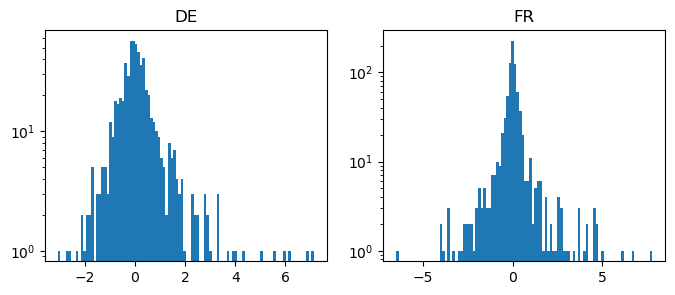

In [24]:
fig, ax = plt.subplots(1,2,figsize=(8,3))
for ii, (key, grp) in enumerate(f_tot.groupby("COUNTRY")):
    ax[ii].hist(np.array(grp["TARGET"]),bins=100)
    # ax[ii].set_xlim([-4,4])
    ax[ii].set_title(key)
    ax[ii].set_yscale("log")


In [25]:
len(f_tot["DAY_ID"])


1494

In [26]:
if remove_collinearities:
    for key in feat.keys():
        ii=0
        while ii < len(feat[key]):
            feature = feat[key][ii]
            mask = (np.abs(corr_matrix[feature]) > 0.98)
            ll = list(corr_matrix[mask].index)
            ll.remove(feature)
            for kk in ll:
                if kk in feat[key]:
                    feat[key].remove(kk)
            ii = ii + 1

        len(feat[key])
feat


{'DE': ['DE_RESIDUAL_LOAD', 'DE_NET_IMPORT'],
 'FR': ['CARBON_RET',
  'AA',
  'GAS_RET',
  'BB',
  'CARBON_RET_DIFF',
  'FR_WINDPOW',
  'FR_RENEW_WO_HYDRO',
  'GAS_RET_DIFF'],
 'tot': ['DE_NET_IMPORT']}

{'DE': ['DE_RESIDUAL_LOAD', 'DE_NET_IMPORT'],
 'FR': ['CARBON_RET',
  'AA',
  'GAS_RET',
  'BB',
  'CARBON_RET_DIFF',
  'FR_WINDPOW',
  'FR_RENEW_WO_HYDRO',
  'GAS_RET_DIFF',
  'FR_NUCLEAR',
  'FR_NUC_AA'],
 'tot': ['DE_NET_IMPORT']}

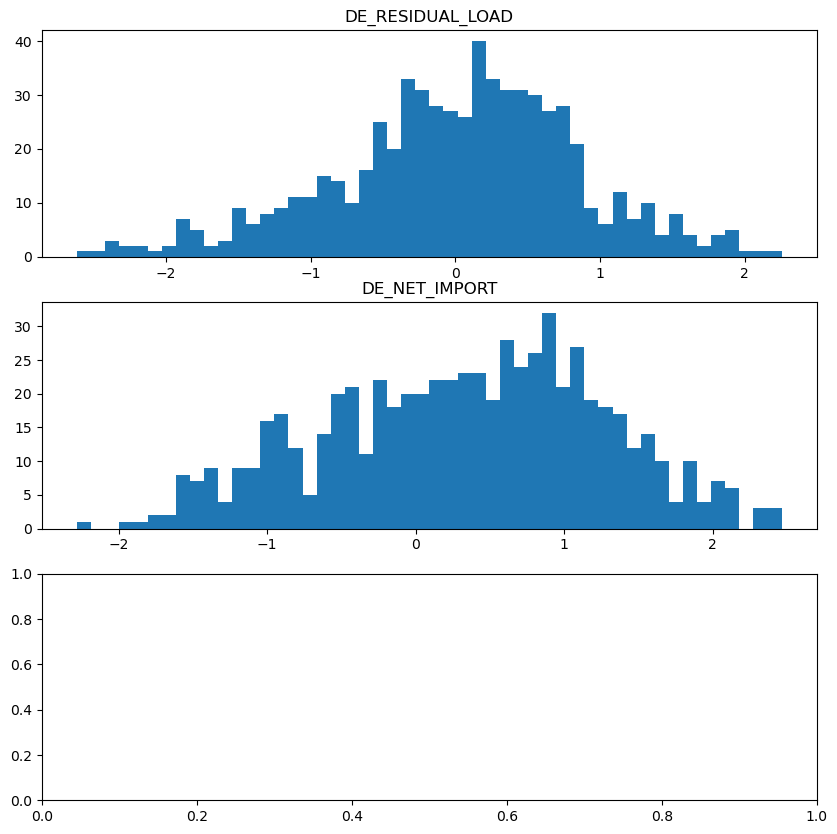

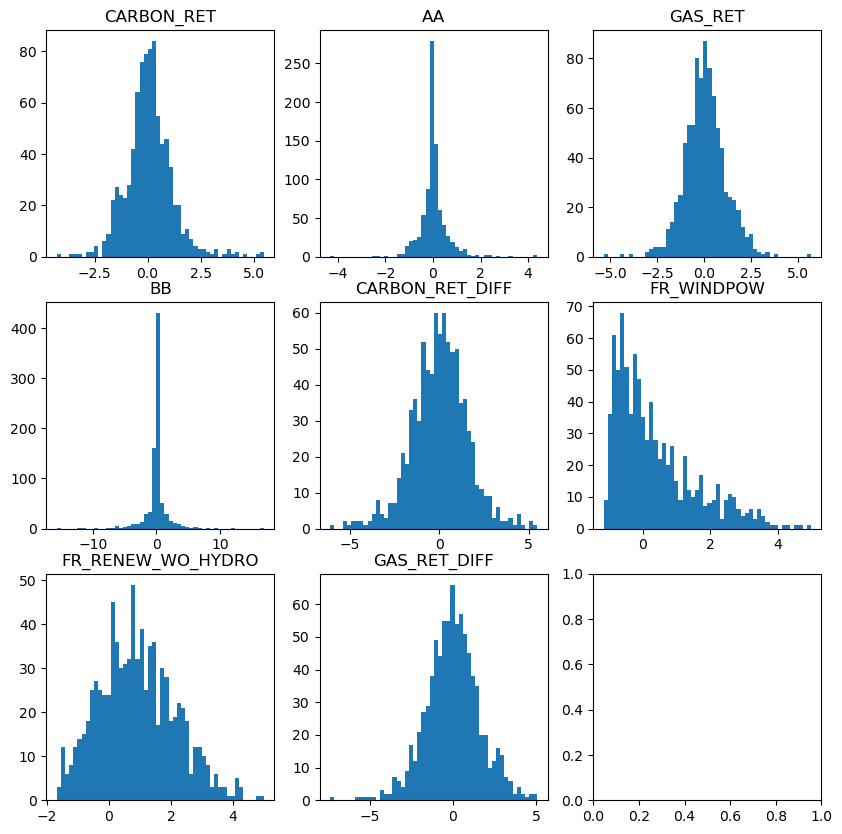

In [27]:
for jj, (key, grp) in enumerate(f_tot.groupby("COUNTRY")):
    fig, ax = plt.subplots(3, int(len(feat[key])/3+1), figsize=(10, 10))
    ax = ax.ravel()
    for ii in range(len(feat[key])):
        col = feat[key][ii]
        ax[ii].hist(grp[col].to_numpy(), bins=50)
        ax[ii].set_title(col)

countries_train = ["FR"]
if len(countries_train) == 1:
    mask = f_tot["COUNTRY"]==countries_train[0]
    f_tot = f_tot[mask]
    for add_feat in  ["FR_NUCLEAR", "FR_WINDPOW","FR_NUC_AA"]:
        if not(add_feat in feat[countries_train[0]]):
            feat[countries_train[0]].append(add_feat)
feat


In [28]:
from sklearn.metrics import mean_squared_error

class metric_obj:
    def __init__(self):
        self.rmse = {}
        self.spear_corr = {}
        self.rmse_tr = {}
        self.spear_corr_tr = {}

    def error_metric(self, f_tot, method,indices_xval, indices_xtrain):
        mask_val_set = indices_xval
        if not(method) in self.rmse.keys():
                self.rmse[method]       = []
                self.spear_corr[method] = []
                self.rmse_tr[method]       = []
                self.spear_corr_tr[method] = []            

        self.rmse[method].append(np.sqrt(mean_squared_error(f_tot.loc[mask_val_set,"TARGET"], f_tot.loc[mask_val_set,method])))
        self.spear_corr[method].append(spearmanr(f_tot.loc[mask_val_set,method], f_tot.loc[mask_val_set,"TARGET"]).correlation)

        mask_tr_set = indices_xtrain
        self.rmse_tr[method].append(np.sqrt(mean_squared_error(f_tot.loc[mask_tr_set,"TARGET"], f_tot.loc[mask_tr_set,method+"train"])))
        self.spear_corr_tr[method].append(spearmanr(f_tot.loc[mask_tr_set,method+"train"], f_tot.loc[mask_tr_set,"TARGET"]).correlation)
        return 



class params_training:
    def __init__(self, max_depth=7, svr_epsilon=0.1, svr_gamma="auto",svr_c = 1, kernel="linear"):
        self.max_depth = max_depth
        self.svr_eps   = svr_epsilon
        self.svr_gamma = svr_gamma
        self.svr_c     = svr_c
        self.kernel     = kernel

# Definisci un "modello" fittizio che restituisce sempre questo valore medio
class AverageModel:
    def __init__(self, constant):
        self.constant = constant
    def predict(self, X):
        return np.full(len(X), self.constant)


metric = metric_obj()  
params = params_training()  


In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression


def features_selection(df_tr, features=[]):
    if len(features) == 0:
       X_train = df_tr.drop(columns=["COUNTRY"]).fillna(0)
    else:
       X_train = df_tr[features].fillna(0)
    return X_train


def correlation_weighting(X_train, y_train, X_val, X_test_feat):
       mi = mutual_info_regression(X_train, y_train, random_state=0)
       mi = pd.Series(mi, index=X_train.columns).sort_values(ascending=False)

       for c in list(X_train.columns):
           weight = 1 + np.abs(mi.loc[c])**1

           X_train[c] = X_train[c] * weight
           X_val[c]   = X_val[c] * weight
           X_test_feat[c]   = X_test_feat[c] * weight

       return X_train, X_val, X_test_feat


In [30]:
def make_pairwise_data(X, y, max_pairs=None):
    n = len(y)
    Z = []
    T = []

    for i in range(n):
        for j in range(i + 1, n):
            if y[i] == y[j]:
                continue
            Z.append(X[i] - X[j])
            T.append(1 if y[i] > y[j] else 0)

            if max_pairs and len(Z) >= max_pairs:
                break
        if max_pairs and len(Z) >= max_pairs:
            break

    return np.asarray(Z), np.asarray(T)



In [31]:
from sklearn.linear_model import Lasso, ElasticNet, SGDClassifier
from sklearn.svm import SVR
import xgboost as xgb
from scipy.stats import rankdata
from sklearn.model_selection import KFold

import pdb




def regression_interface(f_tot, Y_test_submission_all, feat, params, split=False, method="LR", corr_weight=False, scaling_inpt=False, train_by_rank=False, k_fold_cross_validation=False):

       Y_test_submission_all[method] = None
       f_tot[method]                 = np.nan
       f_tot[method+"train"]         = np.nan
       if split:
              for country in countries_train:                            
                     f_tot, Y_test_submission_all = regression_train_with_dataset(f_tot, feat, country, method, Y_test_submission_all, 
                                                                     params, corr_weight, scaling_inpt, train_by_rank, k_fold_cross_validation)
       else:
              country = "tot"
              f_tot, Y_test_submission_all = regression_train_with_dataset(f_tot, feat, country, method, Y_test_submission_all, params, 
                                                              corr_weight, scaling_inpt, train_by_rank, k_fold_cross_validation)

       return Y_test_submission_all, f_tot

def regression_train_with_dataset(df, feat, country, method, Y_test_submission_all, params, corr_weight, scaling_inpt, train_by_rank, k_fold_cross_validation):
       mask    = (X_test["COUNTRY"]==country)
       mask_df = (df["COUNTRY"]==country)
       if country == "tot":
              mask    = ~mask
              mask_df = ~mask_df
       
       X_tot                                = features_selection(df[mask_df].drop(columns=["TARGET"]), feat[country])
       X_test_feat                          = features_selection(X_test[mask],feat[country])
       y_tot                                = df[mask_df]["TARGET"]

       if k_fold_cross_validation:
              kf = KFold(n_splits=N_SPLIT)
              for train_index, test_index in kf.split(X_tot):
                     X_train, X_val = pd.DataFrame(X_tot.iloc[train_index]), pd.DataFrame(X_tot.iloc[test_index])
                     y_train, y_val = y_tot.iloc[train_index], y_tot.iloc[test_index]
                     df, Y_test_submission_all = training_model(X_train, y_train, X_val, y_val, X_test_feat, df, feat, country, method, Y_test_submission_all,
                                     params, corr_weight, scaling_inpt, train_by_rank)

       else:
              X_train, X_val, y_train, y_val       = train_test_split(X_tot, y_tot, test_size=VAL_FRACTION, random_state=1)
              df, Y_test_submission_all = training_model(X_train, y_train, X_val, y_val, X_test_feat, df, feat, country, method, Y_test_submission_all, 
                             params, corr_weight, scaling_inpt, train_by_rank)


       return df, Y_test_submission_all


def training_model(X_train, y_train, X_val, y_val, X_test_feat, df, feat, country, method, Y_test_submission_all, 
                             params, corr_weight, scaling_inpt, train_by_rank):
       indices_xval     = X_val.index
       indices_xtest    = X_test_feat.index
       indices_xtrain   = X_train.index

       if train_by_rank:
              y_train[:] = rankdata(y_train.values)

       if scaling_inpt:
              scaler           = StandardScaler().fit(X_train)
              X_train          = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
              X_val            = pd.DataFrame(scaler.transform(X_val), index=X_val.index, columns=X_val.columns)
              X_test_feat      = pd.DataFrame(scaler.transform(X_test_feat), index=X_test_feat.index, columns=X_test_feat.columns)

       if corr_weight:
              X_train, X_val, X_test_feat = correlation_weighting(X_train, y_train, X_val, X_test_feat)
       X_np = X_train.values        # or X.to_numpy()
       y_np = y_train.values        # if y is a Series


       # print("X_train:", type(X_train), getattr(X_train, "shape", None), getattr(X_train, "dtypes", None))
       # print("y_train:", type(y_train), getattr(y_train, "shape", None), getattr(y_train, "dtype", None))

       # print("X_val:", type(X_val), getattr(X_val, "shape", None), getattr(X_val, "dtypes", None))
       # print("y_val:", type(y_val), getattr(y_val, "shape", None), getattr(y_val, "dtype", None))

       if "classifier" == method:
              Z_train, T_train = make_pairwise_data(X_np, y_np, max_pairs=5000000)
              model = SGDClassifier(loss="log_loss", fit_intercept=False).fit(Z_train, T_train)


       if "LR" == method:
              model                                = LinearRegression().fit(X_train, y_train)
       elif "lasso" == method:
              model                                = Lasso(alpha=0.02, max_iter=100, random_state=0).fit(X_train, y_train)
       elif "elasticnet" == method:
              model                                = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=0).fit(X_train, Y_train)
       elif "svr" == method:
              model                                = SVR(kernel=params.kernel,C=params.svr_c,epsilon=params.svr_eps, gamma=params.svr_gamma).fit(X_train, y_train)
       elif "RF" == method:
              model =  RandomForestRegressor(n_estimators=200,  max_depth=params.max_depth, bootstrap=True, random_state=42).fit(X_train, y_train)
       elif "RFboost" == method:
              model = GradientBoostingRegressor(n_estimators=400, learning_rate=0.01, loss="huber",  
                                          max_depth=4, min_samples_leaf=5, random_state=42).fit(X_train, y_train)
       elif "linearboost" == method:
              model         = LinearRegression().fit(X_train, y_train)
              residual      = y_train - model.predict(X_train)
              model_b       = GradientBoostingRegressor(n_estimators=200, learning_rate=0.02, loss="huber",  
                                          max_depth=3, min_samples_leaf=5, random_state=42).fit(X_train, residual)
       elif "linear_boost" == method:
              model         = LinearRegression().fit(X_train, y_train)
              residual      = y_train - model.predict(X_train)
              model_b       = SVR(kernel=params.kernel,C=params.svr_c,epsilon=params.svr_eps, gamma=params.svr_gamma).fit(X_train, residual)

       elif "xgboost" == method:
  
              dtrain = xgb.DMatrix(X_train.to_numpy(), label=y_train)
              dval   = xgb.DMatrix(X_val.to_numpy(),   label=y_val)
              model = xgb.train(params, dtrain, num_boost_round=500)
              y_pred = model.predict(dval)

              print("spearman:", spearmanr(y_pred, y_val).correlation)
              X_train       = xgb.DMatrix(X_train.to_numpy())
              X_val         = xgb.DMatrix(X_val.to_numpy())
              X_test_feat   = xgb.DMatrix(X_test_feat.to_numpy())

       if not(method=="classifier"):
              y_tr_pred   = model.predict(X_train)      
              y_pred      = model.predict(X_val)            
              Y_test      = model.predict(X_test_feat)
              if 'model_b' in locals():
                     y_tr_pred   += model_b.predict(X_train)      
                     y_pred      += model_b.predict(X_val)            
                     Y_test      += model_b.predict(X_test_feat)

       else:
              w = model.coef_.ravel()
              y_tr_pred  = X_train.to_numpy() @ w
              y_pred = X_val.to_numpy()   @ w
              Y_test     = X_test_feat.to_numpy() @ w
              
       Y_test_submission_all.loc[indices_xtest, method] = Y_test
       df.loc[indices_xval, method]           = y_pred
       df.loc[indices_xtrain, method+"train"] = y_tr_pred

       metric.error_metric(f_tot, method, indices_xval, indices_xtrain)
       return df, Y_test_submission_all

In [32]:
metric.rmse = {}
metric.spear_corr = {}
scaling_inpt=False
train_by_rank = True
N_SPLIT=20
k_fold_cross_valid = True


params = params_training(max_depth=7,svr_epsilon=0.01,svr_gamma=0.01,svr_c=0.01,kernel="rbf")
Y_test_submission_all = X_test[['ID']].copy()

method="LR"
Y_test_submission_all,  f_tot  = regression_interface(f_tot, Y_test_submission_all,  feat, params, split=True, method=method, corr_weight=False, scaling_inpt=scaling_inpt, train_by_rank=train_by_rank, k_fold_cross_validation=k_fold_cross_valid)
print(np.array(metric.rmse[method]).mean(), np.array(metric.spear_corr[method]).mean(), method)


method="lasso"
Y_test_submission_all,  f_tot  = regression_interface(f_tot, Y_test_submission_all,  feat, params, split=True, method=method, corr_weight=False, scaling_inpt=scaling_inpt, train_by_rank=train_by_rank, k_fold_cross_validation=k_fold_cross_valid)
print(np.array(metric.rmse[method]).mean(), np.array(metric.spear_corr[method]).mean(), method)

method="svr"
Y_test_submission_all,  f_tot  = regression_interface(f_tot, Y_test_submission_all,  feat, params, split=True, method=method, corr_weight=False, scaling_inpt=scaling_inpt, train_by_rank=train_by_rank, k_fold_cross_validation=k_fold_cross_valid)
print(np.array(metric.rmse[method]).mean(), np.array(metric.spear_corr[method]).mean(), method)

method="linearboost"
Y_test_submission_all,  f_tot  = regression_interface(f_tot, Y_test_submission_all,  feat, params, split=True, method=method, corr_weight=False, scaling_inpt=scaling_inpt, train_by_rank=train_by_rank, k_fold_cross_validation=k_fold_cross_valid)
print(np.array(metric.rmse[method]).mean(), np.array(metric.spear_corr[method]).mean(), method)

method="linear_boost"
Y_test_submission_all,  f_tot  = regression_interface(f_tot, Y_test_submission_all,  feat, params, split=True, method=method, corr_weight=False, scaling_inpt=scaling_inpt, train_by_rank=train_by_rank, k_fold_cross_validation=k_fold_cross_valid)
print(np.array(metric.rmse[method]).mean(), np.array(metric.spear_corr[method]).mean(), method)

method = "RFboost"
Y_test_submission_all,  f_tot  = regression_interface(f_tot, Y_test_submission_all,  feat, params, split=True, method=method, corr_weight=False, scaling_inpt=scaling_inpt, train_by_rank=train_by_rank, k_fold_cross_validation=k_fold_cross_valid)
print(np.array(metric.rmse[method]).mean(), np.array(metric.spear_corr[method]).mean(), method)

# method="classifier"
# Y_test_submission_all,  f_tot  = regression_interface(f_tot, Y_test_submission_all,  feat, params, split=True, method=method, corr_weight=False, scaling_inpt=True, train_by_rank=True)
# print(np.array(metric.rmse[method]).mean(), np.array(metric.spear_corr[method]).mean(), method)

params = {"booster": "gbtree","objective": "reg:squarederror","eta": 0.02,"max_depth": 15,
    "min_child_weight": 0.2, "subsample": 1, "colsample_bytree": 0.2, "gamma" : 0.5,"reg_alpha": 0.1,  # L1
    "reg_lambda": 2,  # L2
}

method="xgboost"
Y_test_submission_all, f_tot  = regression_interface(f_tot, Y_test_submission_all,  feat, params, split=True, method=method, corr_weight=False, scaling_inpt=scaling_inpt, train_by_rank=train_by_rank, k_fold_cross_validation=k_fold_cross_valid)
print(np.array(metric.rmse[method]).mean(), np.array(metric.spear_corr[method]).mean(), method)



407.80294277783213 0.17974672454624707 LR
407.7987782640219 0.17928687526336887 lasso
404.71512693949626 0.17814302436440477 svr
410.15813746597877 0.1341679952121207 linearboost
404.73701623309427 0.17969000304879953 linear_boost
408.50776613776384 0.12629535036927914 RFboost
spearman: -0.11023859861069163
spearman: -0.04092419208698278
spearman: 0.14693446088794926
spearman: 0.12141347025067956
spearman: 0.20024161884627
spearman: -0.080338266384778
spearman: 0.20824524312896406
spearman: -0.012231954092419207
spearman: 0.25943823618242223
spearman: 0.03820598006644518
spearman: 0.10631229235880398
spearman: 0.07187715252445699
spearman: 0.05696458957945062
spearman: 0.05874726521351593
spearman: 0.13005429057612838
spearman: 0.2554898306458148
spearman: 0.3579126488939309
spearman: -0.027955595170569645
spearman: 0.2815817194716798
spearman: 0.040758447451584155
410.59272374230005 0.10312443198663271 xgboost


In [33]:

print("training set")

for mm in metric.rmse.keys():
    print(np.array(metric.rmse_tr[mm]).mean(), np.array(metric.spear_corr_tr[mm]).mean(), mm)

print("-----------------------------------------")
print("validation set")

for mm in metric.rmse.keys():
    print(np.array(metric.rmse[mm]).mean(), np.array(metric.spear_corr[mm]).mean(), mm)


training set
408.1237282198806 0.22435489187142488 LR
408.1193372009565 0.22437797042311428 lasso
404.7151751021233 0.20668480904219547 svr
410.7357947524486 0.5781221341346914 linearboost
405.05765861438283 0.22437719686871574 linear_boost
413.20128708972777 0.7424256209089433 RFboost
464.9206316229978 0.9999351789374981 xgboost
-----------------------------------------
validation set
407.80294277783213 0.17974672454624707 LR
407.7987782640219 0.17928687526336887 lasso
404.71512693949626 0.17814302436440477 svr
410.15813746597877 0.1341679952121207 linearboost
404.73701623309427 0.17969000304879953 linear_boost
408.50776613776384 0.12629535036927914 RFboost
410.59272374230005 0.10312443198663271 xgboost


In [34]:
max_value = 0
for kk in metric.spear_corr.keys():
    if np.array(metric.spear_corr[kk]).mean() > max_value:
        max_key = kk
        max_value = np.array(metric.spear_corr[kk]).mean()

print(max_key, max_value)

Y_test_submission_G = Y_test_submission_all[['ID']].copy()
Y_test_submission_G["TARGET"] = Y_test_submission_all[max_key]
Y_test_submission_G.to_csv('benchmark_qrt_G.csv', index=False)
Y_test_submission_G.head()


LR 0.17974672454624707


,ID,TARGET
0,1115,425.790611
1,1202,455.472806
2,1194,365.793634
3,1084,440.981833
4,1135,392.656915


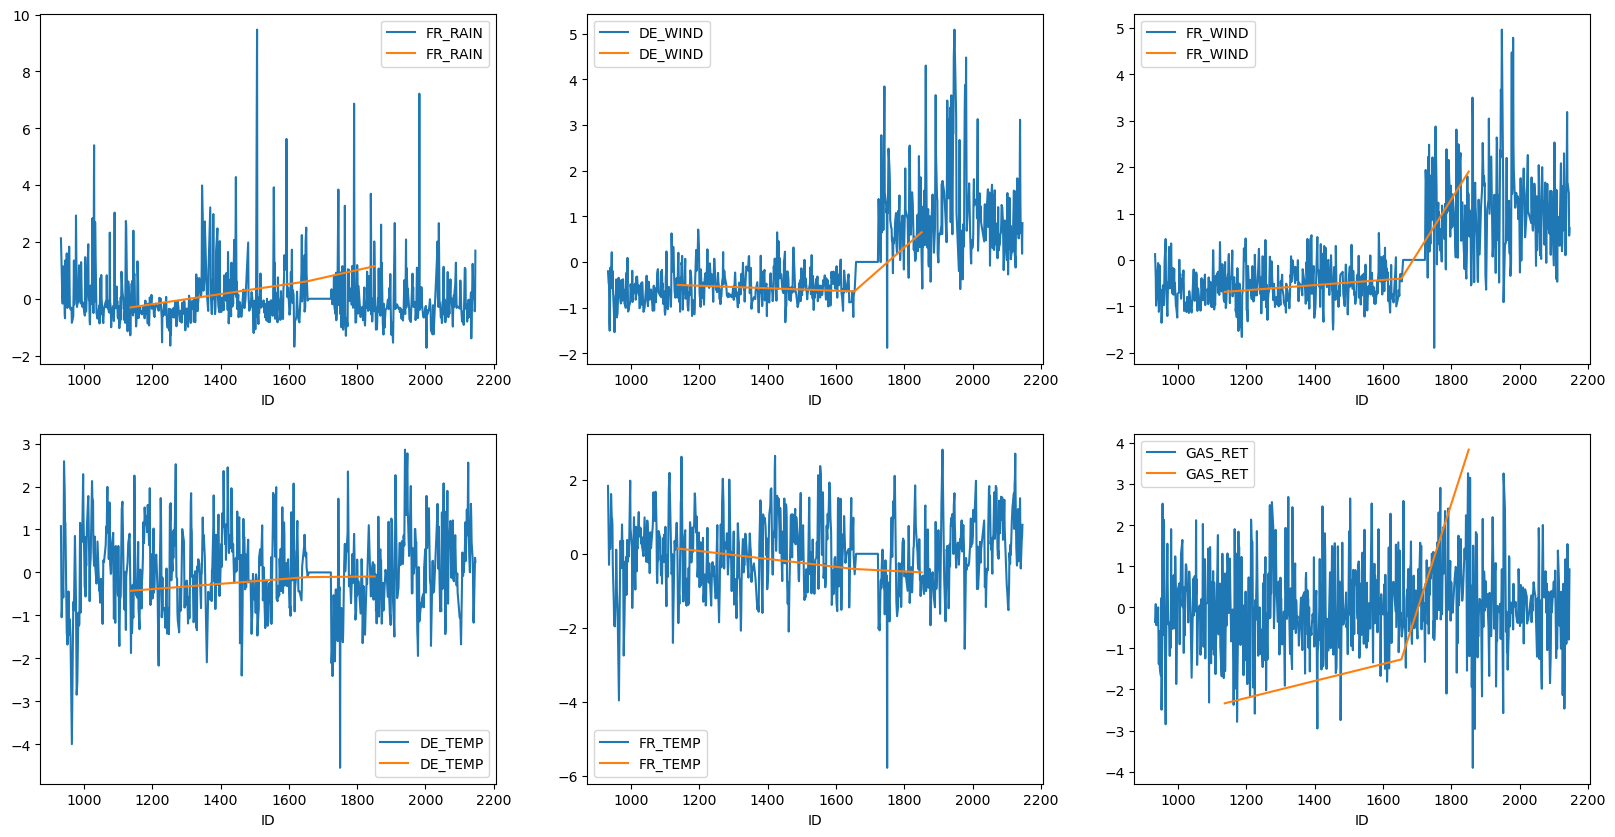

In [35]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))
ax = ax.flatten()
mask_up = f_tot["TARGET"] > 6
mask_down = f_tot["TARGET"] < 0.5
kk = -1
# Change the slice from [0:10] to [0:6]
for ii in list(f_tot.drop(columns=["COUNTRY"]).columns)[26:32]:
    kk = kk + 1
    f_tot[mask_down].sort_values(by="ID", ascending=True).plot(x="ID", y=ii, ax=ax[kk])
    f_tot[mask_up].sort_values(by="ID", ascending=True).plot(x="ID", y=ii, ax=ax[kk])




In [36]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau


def NN_prep(f_tot, X_test, country, criterion, residual_meth=None):
    mask_tr   = (f_tot["COUNTRY"] == country)
    mask_test = (X_test["COUNTRY"] == country)

    if country == "tot":
        mask_tr   = ~mask_tr
        mask_test = ~mask_test
    
    X_tot                                = features_selection(f_tot[mask_tr].drop(columns=["TARGET"]), feat["tot"])
    X_test_feat                          = features_selection(X_test[mask_test],feat["tot"])

    if residual_meth is not None:    
        y_tot = f_tot[mask_tr]["TARGET"] - f_tot[mask_tr][residual_meth + "train"].fillna(f_tot[residual_meth])

        if isinstance(criterion, nn.HuberLoss):
            delta = criterion.delta  # usa 1.0 se non esiste
            y_tot = y_tot.clip(-delta, delta)         # <-- CLIPPING in pandas

    else:
        y_tot = f_tot[mask_tr]["TARGET"]

    X_train, X_val, Y_train, Y_val       = train_test_split(X_tot, y_tot, test_size=VAL_FRACTION, random_state=1)

    scaler           = StandardScaler().fit(X_train)
    X_train          = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_val            = pd.DataFrame(scaler.transform(X_val), index=X_val.index, columns=X_val.columns)
    X_test_feat      = pd.DataFrame(scaler.transform(X_test_feat), index=X_test_feat.index, columns=X_test_feat.columns)


    x_train = torch.tensor(X_train.values, dtype=torch.float32).view(-1, len(feat["tot"]))
    y_train = torch.tensor(Y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
    x_val   = torch.tensor(X_val.values, dtype=torch.float32).view(-1, len(feat["tot"]))
    y_val   = torch.tensor(Y_val.to_numpy(), dtype=torch.float32).view(-1, 1)
    # print("shape of torch tensor is: ")
    # print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

    # Setup data loaders for batch
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    val_dataset = TensorDataset(x_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    return val_loader, val_dataset, train_loader, train_dataset, X_test_feat, X_train, Y_train, X_val, Y_val


In [37]:
import torch.nn.functional as F
class MLPModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        # self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)
        self.fdrop_1 =  nn.Dropout(p=0.0)   # ← qui
        self.fdrop_2 =  nn.Dropout(p=0.0)   # ← qui

    def forward(self, x):
        # x = self.fc1(x)
        x = F.relu(self.fc1(x))

        x = self.fdrop_1(x)

        x = F.relu(self.fc3(x))
        x = self.fdrop_2(x)

        x = F.relu(self.fc4(x))

        x = self.fc5(x)
        return x.squeeze(1)  #
    


def training_NN(model, val_loader, train_loader, criterion, optimizer, epochs, scheduler, l1_lambda, l2_lambda, early_stop_treshold, verbose=False):
    early_stop_count = 0
    min_val_loss = float('inf')

    # FIX 1: inizializza SEMPRE best_state
    best_state = {k: v.detach().clone() for k, v in model.state_dict().items()}

    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            x_batch, y_batch = batch
            y_batch = y_batch.squeeze(-1)

            optimizer.zero_grad()
            # outputs = model(x_batch).squeeze(-1)
            outputs = model(x_batch).view(-1)
            loss = criterion(outputs, y_batch)

            # aggiungo manualmente la L1 e la l2
            l1_norm = sum(p.abs().sum() for p in model.parameters())

            l2_norm = sum(p.pow(2).sum() for p in model.parameters())

            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm

            train_losses.append(loss.item())

            # FIX 2: salta batch con NaN
            if not torch.isfinite(loss):
                continue

            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch in val_loader:
                x_batch, y_batch = batch
                y_batch = y_batch.squeeze(-1)

                # outputs = model(x_batch).squeeze(-1)
                outputs = model(x_batch).view(-1)
                loss = criterion(outputs, y_batch)

                if torch.isfinite(loss):
                    val_losses.append(loss.item())

        if len(val_losses) == 0:
            continue

        val_loss = np.mean(val_losses)
        scheduler.step(val_loss)

        # FIX 3: early stopping SOLO su val_loss
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            best_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
            early_stop_count = 0
        else:
            early_stop_count += 1

        if early_stop_count >= early_stop_treshold:
            if verbose:
                print("Early stopping!")
            break

        if epoch % 5 == 0 and verbose:
            print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.8f}, Train Loss: {np.mean(train_losses):.8f}")

    # FIX 4: best_state ora è SEMPRE valido
    model.load_state_dict(best_state)
    return model




def pred_NN_learning(model, Y_test_submission_all, df, X_train, Y_train, X_val, Y_val, X_test_feat, method, alpha_boost, boosting_met ):
    model.eval()
    with torch.no_grad():
        x_train = torch.tensor(X_train.values, dtype=torch.float32).view(-1, len(feat["tot"]))
        x_val   = torch.tensor(X_val.values, dtype=torch.float32).view(-1, len(feat["tot"]))
        x_test  = torch.tensor(X_test_feat.values, dtype=torch.float32).view(-1, len(feat["tot"]))

        y_pred_train = model(x_train).numpy()  
        y_pred_val  = model(x_val).numpy() 

        Y_test       = model(x_test).numpy()

        if not(boosting_met == None):
            # y_pred_val  = df.loc[X_val.index, boosting_met].fillna(df.loc[X_val.index, boosting_met+"train"])   + alpha_boost * y_pred_val 
            y_pred_val  = df.loc[X_val.index, boosting_met]  + alpha_boost * y_pred_val 
            y_pred_train = df.loc[X_train.index, boosting_met+"train"]+ alpha_boost * y_pred_train
            Y_test       = Y_test_submission_all.loc[X_test_feat.index, boosting_met] + alpha_boost * Y_test


        df.loc[X_val.index, method]           = y_pred_val
        df.loc[X_train.index, method+"train"] = y_pred_train

        Y_test_submission_all.loc[X_test_feat.index, method] = Y_test
   
    return df


def plot_learning(f_tot,method, figsize=(10,4)):
        

    fig,ax = plt.subplots(nrows=1,ncols=2,figsize=figsize)
    fig.subplots_adjust(wspace=0.4)

    for jj, (key, df) in enumerate(f_tot.groupby("COUNTRY")):
        mask_tr    =  np.isfinite(df[method+"train"])
        mask_val   =  np.isfinite(df[method])
        ax[1].scatter(df[mask_tr]["TARGET"], df[mask_tr][method+"train"], s=5, alpha=0.5,label=key)
        ax[1].set_xlabel("True y (train)")
        ax[1].set_ylabel("Predicted y")
        ax[1].set_title("Train fit "+method)
        ax[1].plot([df[mask_tr]["TARGET"].min(), df[mask_tr]["TARGET"].max()], [df[mask_tr]["TARGET"].min(), df[mask_tr]["TARGET"].max()], 'r--')
        ax[1].set_xlim([-3,3])
        ax[1].set_ylim([df[mask_tr][method+"train"].min(),df[mask_tr][method+"train"].max()])

        ax[0].scatter(df[mask_val]["TARGET"], df[mask_val][method], s=5, alpha=0.5)
        ax[0].plot([df[mask_val]["TARGET"].min(), df[mask_val]["TARGET"].max()], [df[mask_val]["TARGET"].min(), df[mask_val]["TARGET"].max()], 'r--')

        ax[0].set_xlabel("True y (test)")
        ax[0].set_ylabel("Predicted y")
        ax[0].set_title("Test fit "+method)
        # ax[0].plot([df[mask_val]["TARGET"].min(), df[mask_val]["TARGET"].max()], [df[mask_val]["TARGET"].min(), df[mask_val]["TARGET"].max()], 'r--')

        ax[0].set_xlim([-2,2])
        ax[0].set_ylim([df[mask_val][method].min(),df[mask_val][method].max()])
    ax[1].legend()
    
    return 

Epoch 1/200, Validation Loss: 0.95156324, Train Loss: 1.88431497
Epoch 6/200, Validation Loss: 0.95057197, Train Loss: 1.20428222
Epoch 11/200, Validation Loss: 0.95403957, Train Loss: 1.27883954
Epoch 16/200, Validation Loss: 0.95125844, Train Loss: 1.14953488
Epoch 21/200, Validation Loss: 0.95210556, Train Loss: 1.14457938
Epoch 26/200, Validation Loss: 0.95119112, Train Loss: 1.12196041
Epoch 31/200, Validation Loss: 0.95086947, Train Loss: 1.11836031
Epoch 36/200, Validation Loss: 0.95048246, Train Loss: 1.09884153
Epoch 41/200, Validation Loss: 0.95042121, Train Loss: 1.09080376
Epoch 46/200, Validation Loss: 0.95046913, Train Loss: 1.09650405
Epoch 51/200, Validation Loss: 0.95055113, Train Loss: 1.09985123
Epoch 56/200, Validation Loss: 0.95010059, Train Loss: 1.07589194
Epoch 61/200, Validation Loss: 0.95003720, Train Loss: 1.07883482
Epoch 66/200, Validation Loss: 0.94976184, Train Loss: 1.07368872
Epoch 71/200, Validation Loss: 0.94961534, Train Loss: 1.08145704
Epoch 76/200

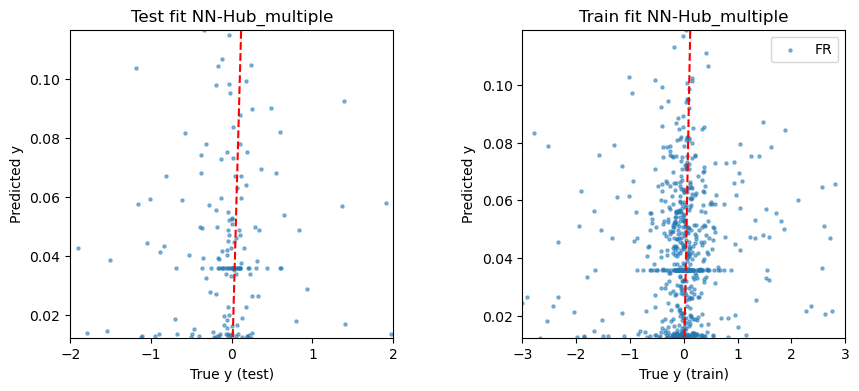

In [38]:

NN = True

if NN:
    epochs = 200
    starting_methods = ["xgboost", "RFboost","LR","svr",None,"lasso","linearboost"]
    starting_methods = [None]
    alpha_boost = 0.5
    early_stop_treshold = 1000
    old_spear_corr = 0
    verbose = True
    ori_methods = ["NN-Hub_multiple"]

    l1_lambda = 1e-3
    l2_lambda = 0*1e-5

    for initial_pred in starting_methods:
        methods     = ori_methods.copy()
        if not(initial_pred == None):
            for ii in range(len(ori_methods)):
                methods[ii] = initial_pred+ori_methods[ii]

        # for method, criterion in zip(["NN-Hub","NN"], [nn.HuberLoss(), nn.MSELoss()]):
        for method, criterion in zip(methods, [nn.MSELoss()]):
            boosting_met    = initial_pred
            criterion_boost = nn.MSELoss() 
            for iter_boost in range(1):
                # if iter_boost == 1:
                #     f_tot.drop(columns=[method], inplace=True)
                #     f_tot.drop(columns=[method+"train"], inplace=True)

                for country in countries_train:
                    
                    test_loader, test_dataset, train_loader, train_dataset, X_test_feat, X_train, Y_train, X_val, Y_val =  NN_prep(f_tot, X_test, country, criterion_boost, residual_meth=boosting_met)
                    x_train = torch.tensor(X_train.values, dtype=torch.float32).view(-1, len(feat["tot"]))

                    model = MLPModel(input_dim=x_train.shape[1])
                    
                    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay = 0.1)
                    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.8, patience=100)
                    model = training_NN(model,test_loader, train_loader, criterion, optimizer,epochs,scheduler, l1_lambda, l2_lambda, early_stop_treshold, verbose)

                    f_tot = pred_NN_learning(model, Y_test_submission_all, f_tot, X_train, Y_train, X_val, Y_val, X_test_feat, method, alpha_boost, boosting_met )

                # plot_learning(f_tot,"NN-Hub_multiple",figsize=(6,3))
                # plt.show()


                boosting_met    = method
                criterion_boost = criterion

                metric.error_metric(f_tot, method, X_val.index, X_train.index)
                if not(initial_pred==None):
                    diff = f_tot.loc[X_val.index, method] - f_tot.loc[X_val.index, initial_pred]
                    print(method, initial_pred)
                    print(metric.spear_corr[method], metric.spear_corr[initial_pred])
                    print("-----------------------------")
                else:
                    print(metric.spear_corr[method])


plot_learning(f_tot,"NN-Hub_multiple")


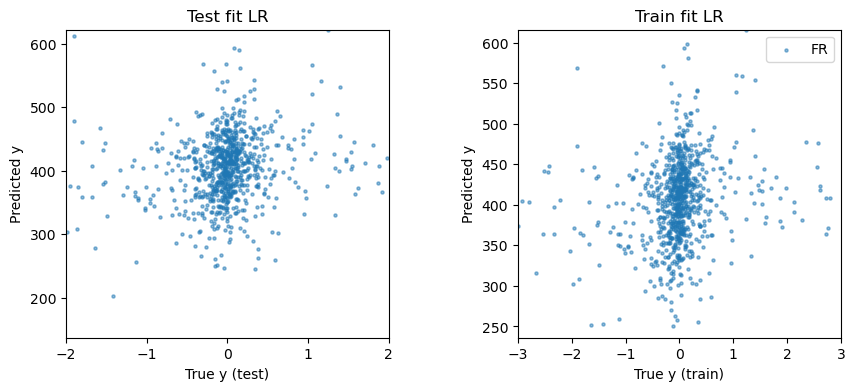

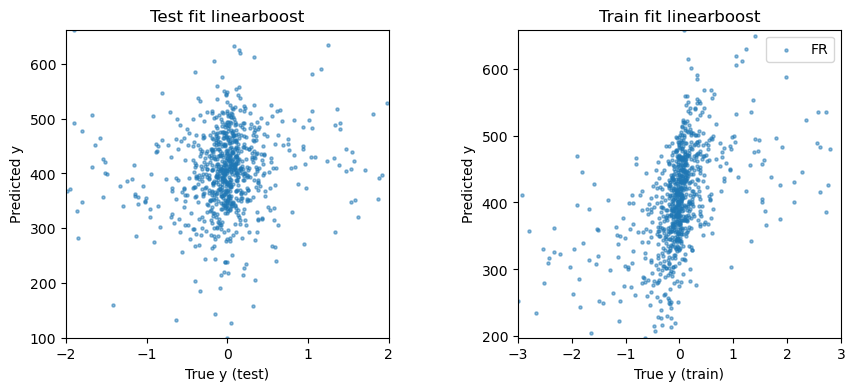

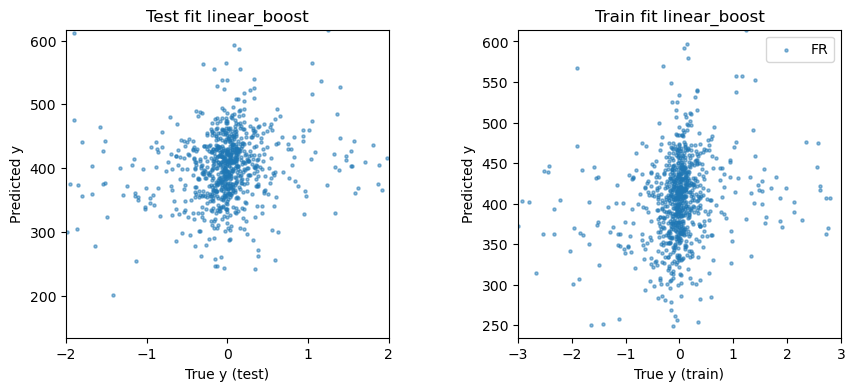

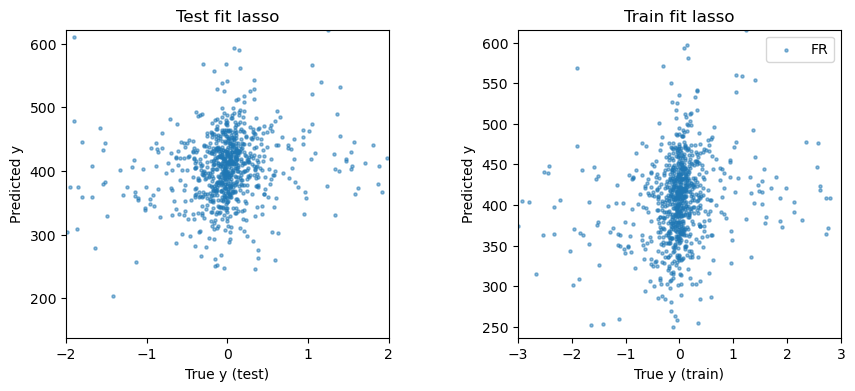

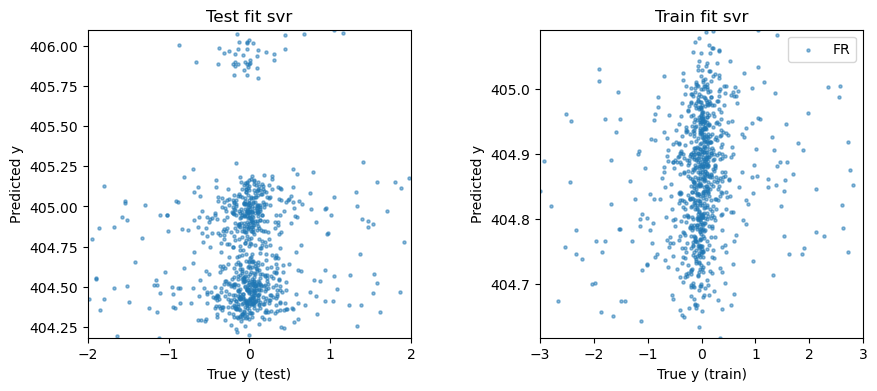

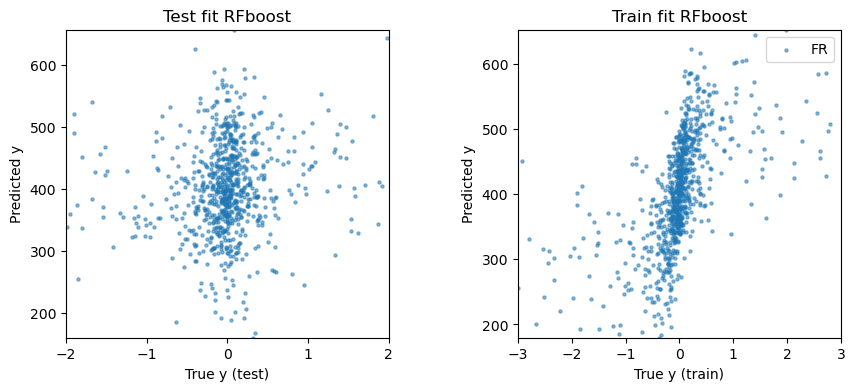

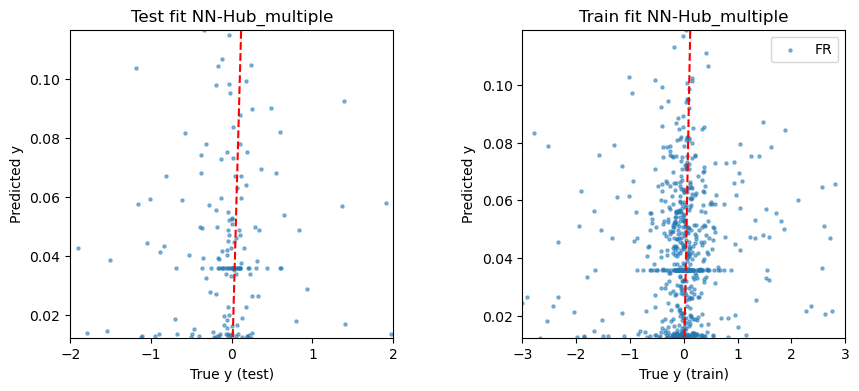

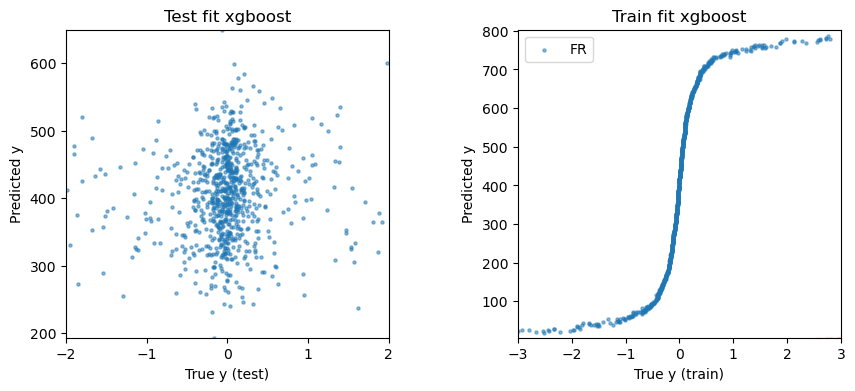

In [39]:
plot_learning(f_tot,"LR")
plot_learning(f_tot,"linearboost")
plot_learning(f_tot,"linear_boost")
plot_learning(f_tot,"lasso")
plot_learning(f_tot,"svr")
# plot_learning(f_tot,"NN")
# plot_learning(f_tot,"NN-Hub")
plot_learning(f_tot,"RFboost")
# plot_learning(f_tot,"classifier")
plot_learning(f_tot,"NN-Hub_multiple")
plot_learning(f_tot,"xgboost")
# plot_learning(f_tot,"xgboostNN-Hub_multiple")
# plot_learning(f_tot,"NN-Hub_multiple")



In [40]:
print("training set")

for mm in metric.rmse.keys():
    print(metric.rmse_tr[mm], metric.spear_corr_tr[mm], mm)

print("-----------------------------------------")

print("validation set")

for mm in metric.rmse.keys():
    print(metric.rmse[mm], metric.spear_corr[mm], mm)

training set
[np.float64(408.1469700625009), np.float64(407.7502169428673), np.float64(407.6553998985564), np.float64(407.90523882409786), np.float64(407.82128412151303), np.float64(408.08594582067803), np.float64(408.1642200521217), np.float64(407.9195911961142), np.float64(407.7452821694048), np.float64(408.2805058811386), np.float64(407.59016004783524), np.float64(408.29675421183083), np.float64(409.0355785863088), np.float64(408.82177375788575), np.float64(408.23691836792545), np.float64(408.22557910658605), np.float64(408.1661893877834), np.float64(408.27078004159847), np.float64(408.03116204542687), np.float64(408.32501387543834)] [np.float64(0.23069513754479995), np.float64(0.2233470901265588), np.float64(0.2127613898888874), np.float64(0.22398523529645814), np.float64(0.2267643473432026), np.float64(0.23580964247306688), np.float64(0.2338079785751653), np.float64(0.22502815550740338), np.float64(0.22011577003213964), np.float64(0.2338409356085182), np.float64(0.2152130596421882

In [41]:
Y_test_submission_G = Y_test_submission_all[['ID']].copy()
Y_test_submission_G["TARGET"] = Y_test_submission_all["RFboost"]
Y_test_submission_G.to_csv('benchmark_qrt_G.csv', index=False)
Y_test_submission_G.head()

,ID,TARGET
0,1115,437.695967
1,1202,477.892603
2,1194,355.36238
3,1084,417.304156
4,1135,376.779363


In [42]:
feat

{'DE': ['DE_RESIDUAL_LOAD', 'DE_NET_IMPORT'],
 'FR': ['CARBON_RET',
  'AA',
  'GAS_RET',
  'BB',
  'CARBON_RET_DIFF',
  'FR_WINDPOW',
  'FR_RENEW_WO_HYDRO',
  'GAS_RET_DIFF',
  'FR_NUCLEAR',
  'FR_NUC_AA'],
 'tot': ['DE_NET_IMPORT']}

KeyError: 'RFboostNN-Hub_multiple'

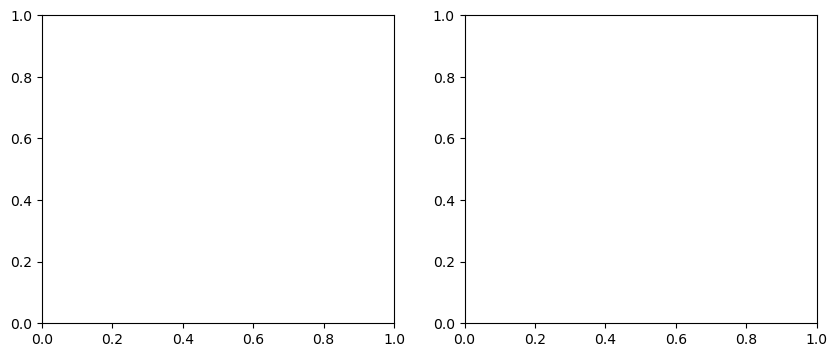

In [43]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,4))

model_x = ["RFboostNN-Hub_multiple", "xgboostNN-Hub_multiple"]
model_y = ["LR", "RFboostNN-Hub_multiple", "xgboostNN-Hub_multiple", "RFboost","xgboost","svr","lasso", "linearboost"]
ii=-1
for mx in model_x:
    ii = ii +1
    for my in model_y:
        if my == mx:
            continue
        ax[ii].plot(Y_test_submission_all[mx], Y_test_submission_all[my],".",label=my)
        ax[ii].set_title(mx)
        ax[ii].legend(framealpha=0.0)
        ax[ii].set_ylim([-1,1])
        
